# TensorRT

Torch-TensorRT is a new integration of PyTorch with NVIDIA TensorRT, which accelerates the inference with one line of code. 

Here I wanted to test whether we can speed up inference of our Unet using Torch-TensorRT.

Torch-TensorRT can be used to speed up inference. This is useful when performing inference in real-time settings.

TensorRT engine (models) are used in the DeepStream framework to speed up real-time inference. 

## Docker container

I decided to test TensorRT using docker containers. The NVIDIA PyTorch container contains `torch_tensorrt` that we can use to test tensorrt.

https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch/tags

You should run the code of this notebook from within the docker container. For information on how to do this, check the documentation: 

https://github.com/kevin-allen/unetTracker/blob/main/documentation/docker.md


## Creating a TensorRT model from a PyTorch model

You will have to generate the TensorRT model on the computer that you want to use it for inference.

In [2]:
# If you are working in a docker container
! cd /usr/src/app/repo/unetTracker && ! python3 -m pip install -e .
# restart your kernel after this ran

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///usr/src/app/repo/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=15273 sha256=83d40ad58920199858fd138805fac1b2180ea35c42003dc340f5aa900f0a7567
  Stored in directory: /tmp/pip-ephem-wheel-cache-of_vw1n3/wheels/5d/e0/64/485540bb11873b73ebea6b354ad89933aadb1a523ad2a42c5c
Successfully built unetTracker


Restart your kernel befor continuing.

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask
from datetime import datetime
import matplotlib.pyplot as plt
from unetTracker.utils import label_video
import torch
import pickle
import torch_tensorrt

In [3]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'unet_features': [64, 128, 256, 512], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [0.5110162496566772, 0.4608974754810333, 0.4772901237010956], 'stds': [0.2727729380130768, 0.2578601539134979, 0.256255567073822]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [37]:
TRAIN_IMAGE_DIR = os.path.join(project.dataset_dir,"train_images")
TRAIN_MASK_DIR =  os.path.join(project.dataset_dir,"train_masks")
TRAIN_COORDINATE_DIR = os.path.join(project.dataset_dir,"train_coordinates")
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")

DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 
BATCH_SIZE = 1
NUM_WORKERS = 4
PIN_MEMORY=False
print(DEVICE)

fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

cuda
Loading valTransform from /home/kevin/Documents/trackingProjects/faceTrack/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.5110162496566772, 0.4608974754810333, 0.4772901237010956], std=[0.2727729380130768, 0.2578601539134979, 0.256255567073822], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [38]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform) 
trainDataset = UNetDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATE_DIR, transform=valTransform) # use same transform as for val
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)
trainLoader = DataLoader(trainDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

In [39]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [40]:
imageIndex=1
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

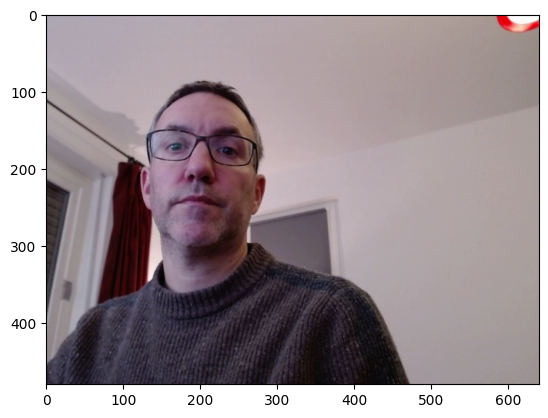

In [41]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [42]:
cDetector = CoordinatesFromSegmentationMask()

In [43]:
def check_accuracy(model,loader,device):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    num_mask = 0
    num_mask_detected = 0
    num_detected = 0
    sum_distance = 0

    model.eval()
    
    start_time = datetime.now()
    with torch.no_grad():
        for x,y,c in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = torch.sigmoid(model(x))
            preds = (output > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds * y).sum() / ((preds+y).sum() + 1e-8)) # work only for binary

            # proportion of the mask detected
            num_mask += y.sum()
            num_mask_detected += preds[y==1.0].sum()
            num_detected += preds.sum()

            # distance between predicted coordinates and labelled coordinates
            output = output.detach().cpu().numpy()
            pred_coords = cDetector.detect(output)

            sum_distance+= np.nanmean(np.sqrt(((pred_coords[:,:,0:2] - c.numpy())**2).sum(axis=2)))
            # we acutally do a mean of the error for the different objects in a batch

    end_time = datetime.now()
    duration = end_time-start_time

    print(f"Total duration: {duration.total_seconds()} sec")
    print(f"Mean time per batch: {(duration/len(loader)).total_seconds()} sec")
    print(f"Accuracy: {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader):.2f}")
    print(f"Mask pixels detected: {num_mask_detected/num_mask*100:.2f}%")
    print(f"False positives: {(num_detected-num_mask_detected)/num_detected*100:.2f}%")
    print(f"Mean error (distance in pixels): {sum_distance/len(loader)}")
    a = model.train()     

We can use our function to get an idea of the speed.

In [44]:
check_accuracy(model,valLoader,DEVICE)

Total duration: 5.804701 sec
Mean time per batch: 0.054761 sec
Accuracy: 99.97
Dice score: 0.82
Mask pixels detected: 79.28%
False positives: 15.10%
Mean error (distance in pixels): 4.5864310503415755


In [45]:
x,y,c = next(iter(valLoader))
x.shape

torch.Size([1, 3, 480, 640])

In [46]:
model.eval()
with torch.no_grad():
    out = model(x.to(DEVICE))

TorchScript records its definitions in an Intermediate Representation (or IR), commonly referred to in Deep learning as a graph. 
We can examine the graph with the .graph property:

In [47]:
traced_model = torch.jit.trace(model, x.to(DEVICE))

/usr/src/app/repo/unetTracker/unetTracker/unet.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape != skip_connection.shape:


In [48]:
check_accuracy(traced_model,valLoader,DEVICE)

Total duration: 9.438925 sec
Mean time per batch: 0.089046 sec
Accuracy: 99.97
Dice score: 0.82
Mask pixels detected: 79.28%
False positives: 15.10%
Mean error (distance in pixels): 4.586766553960307


In [49]:
trt_module = torch_tensorrt.compile(traced_model,
    inputs = [torch_tensorrt.Input((BATCH_SIZE, 3, 480, 640))], # input shape   
    enabled_precisions = {torch_tensorrt.dtype.half} # Run with FP16
)

In [50]:
# save the TensorRT embedded Torchscript
fn = os.path.join(project.models_dir,"trt_torchscript_module.ts")
print("Saving TRT torchscript module to",fn)
torch.jit.save(trt_module, fn)

Saving TRT torchscript module to /home/kevin/Documents/trackingProjects/faceTrack/models/trt_torchscript_module.ts


In [51]:
check_accuracy(trt_module,valLoader,DEVICE)

Total duration: 3.326346 sec
Mean time per batch: 0.031381 sec
Accuracy: 99.97
Dice score: 0.82
Mask pixels detected: 79.27%
False positives: 15.10%
Mean error (distance in pixels): 4.418103969734727


## Create a TensorRT engine for DeepStream

In [53]:
# export the model to ONNX
fn = os.path.join(project.models_dir,"UNet.onnx")
print("Saving onnx torchscript module to",fn)
torch.onnx.export(traced_model, x.to(DEVICE), fn, verbose=False)

Saving onnx torchscript module to /home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx


In [32]:
!trtexec --onnx=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx  --saveEngine=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec [TensorRT v8501] # trtexec --onnx=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx --saveEngine=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet.trt --explicitBatch
[12/20/2022-19:59:40] [W] --explicitBatch flag has been deprecated and has no effect!
[12/20/2022-19:59:40] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[12/20/2022-19:59:40] [I] === Model Options ===
[12/20/2022-19:59:40] [I] Format: ONNX
[12/20/2022-19:59:40] [I] Model: /home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx
[12/20/2022-19:59:40] [I] Output:
[12/20/2022-19:59:40] [I] === Build Options ===
[12/20/2022-19:59:40] [I] Max batch: explicit batch
[12/20/2022-19:59:40] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[12/20/2022-19:59:40] [I] minTiming: 1
[12/20/2022-19:59:40] [I] avgTiming: 8
[12/20/2022-19:

In [34]:
!trtexec --onnx=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx --saveEngine=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet_fp16.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16

&&&& RUNNING TensorRT.trtexec [TensorRT v8501] # trtexec --onnx=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx --saveEngine=/home/kevin/Documents/trackingProjects/faceTrack/models/UNet_fp16.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
[12/20/2022-20:04:26] [W] --explicitBatch flag has been deprecated and has no effect!
[12/20/2022-20:04:26] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[12/20/2022-20:04:26] [I] === Model Options ===
[12/20/2022-20:04:26] [I] Format: ONNX
[12/20/2022-20:04:26] [I] Model: /home/kevin/Documents/trackingProjects/faceTrack/models/UNet.onnx
[12/20/2022-20:04:26] [I] Output:
[12/20/2022-20:04:26] [I] === Build Options ===
[12/20/2022-20:04:26] [I] Max batch: explicit batch
[12/20/2022-20:04:26] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[12/20/2022-20:04:26] [I] mi